# XGBoost

In [1]:
# Import bibliotek
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score, roc_auc_score, precision_recall_fscore_support, roc_curve, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTENC
import xgboost as xgb

warnings.filterwarnings('ignore')

In [2]:
# === Załadowanie danych ===
train_df = pd.read_csv('train_df.csv', index_col=0)
test_df = pd.read_csv('test_df.csv', index_col=0)

# Dodanie kolumny `__is_train` w celu rozróżnienia zbiorów
train_df['__is_train'] = 1
test_df['__is_train'] = 0

# Połączenie zbiorów
combined = pd.concat([train_df, test_df], axis=0)

# One-Hot Encoding
combined = pd.get_dummies(combined, drop_first=True)
train_df = combined[combined['__is_train'] == 1].drop(columns='__is_train')
test_df = combined[combined['__is_train'] == 0].drop(columns='__is_train')

# Podział na cechy (X) i etykiety (y)
X_train = train_df.drop('stroke', axis=1)
y_train = train_df['stroke']
X_test = test_df.drop('stroke', axis=1)
y_test = test_df['stroke']


In [3]:
# Indeksy cech kategorycznych po One-Hot Encoding
index_of_categorical_features = [1, 2, 5, 6, 7, 8, 9, 10, 11]

# === Zastosowanie SMOTENC ===
sm = SMOTENC(categorical_features=index_of_categorical_features, random_state=42, sampling_strategy='auto')
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

print("Rozmiar danych po SMOTENC:")
print("X_train_resampled shape:", X_train_resampled.shape)
print("y_train_resampled shape:", y_train_resampled.shape)

Rozmiar danych po SMOTENC:
X_train_resampled shape: (7784, 12)
y_train_resampled shape: (7784,)


## GridSearchCV – dobór optymalnych hiperparametrów

In [5]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'scale_pos_weight': [1, 5, 10]
}

xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    random_state=42
)

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    verbose=0
)

print("Rozpoczynam Grid Search dla XGBoost...")
grid_search.fit(X_train_resampled, y_train_resampled)

# Najlepsze parametry
print("Najlepsze parametry:", grid_search.best_params_)
print("Najlepszy wynik AUC na zbiorze walidacyjnym:", grid_search.best_score_)

Rozpoczynam Grid Search dla XGBoost...
Najlepsze parametry: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 150, 'scale_pos_weight': 5, 'subsample': 0.8}
Najlepszy wynik AUC na zbiorze walidacyjnym: 0.9827081034667234


In [6]:
# === Inicjalizacja modelu z najlepszymi parametrami ===
best_xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    random_state=42,
    **grid_search.best_params_  # Wstawiamy najlepsze parametry automatycznie
)

In [7]:
# === Trenowanie modelu na danych po SMOTENC ===
print("Training the XGBoost model with best parameters...")
best_xgb_model.fit(X_train_resampled, y_train_resampled)


Training the XGBoost model with best parameters...


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=150,
              n_jobs=None, num_parallel_tree=None, ...)

## Ocena modelu i prezentacja metryk

In [8]:
# === Ocena modelu na zbiorze testowym ===
print("\nXGBoost Evaluation:")

# Przewidywanie prawdopodobieństw
y_proba = best_xgb_model.predict_proba(X_test)[:, 1]

# Zastosowanie progu 0.5 do generowania prognoz binarnych
y_pred = (y_proba >= 0.5).astype(int)

# Obliczanie metryk
from sklearn.metrics import recall_score, roc_auc_score, precision_recall_fscore_support

auc = roc_auc_score(y_test, y_proba)
recall = recall_score(y_test, y_pred)
precision, recall_macro, f1_score_macro, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')

# Wyświetlenie wyników
print(f"AUC: {auc:.4f}")
print(f"TPR (Recall): {recall:.4f}")
print(f"Macro avg Precision: {precision:.4f}")
print(f"Macro avg Recall: {recall_macro:.4f}")
print(f"Macro avg F1-score: {f1_score_macro:.4f}")


XGBoost Evaluation:
AUC: 0.7159
TPR (Recall): 0.2037
Macro avg Precision: 0.5233
Macro avg Recall: 0.5471
Macro avg F1-score: 0.5246


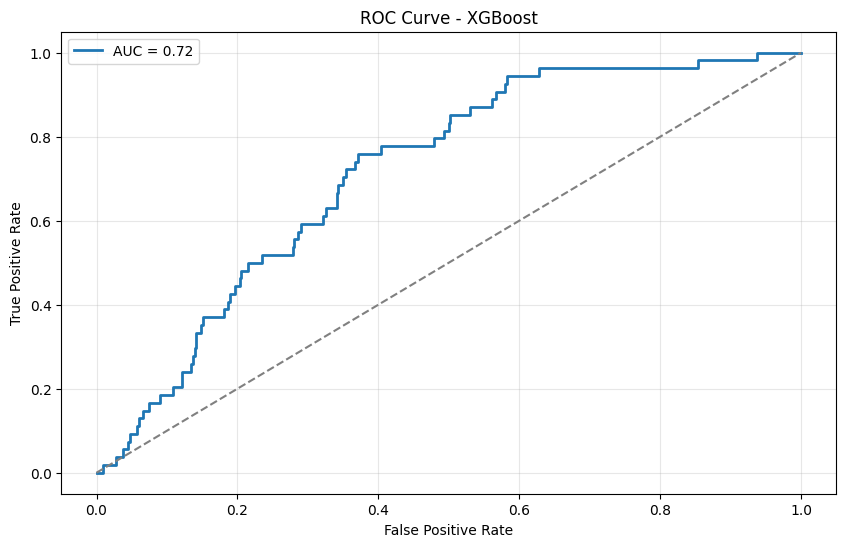

In [9]:
# === Wizualizacja ROC Curve ===
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label="AUC = {:.2f}".format(auc), linewidth=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - XGBoost")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

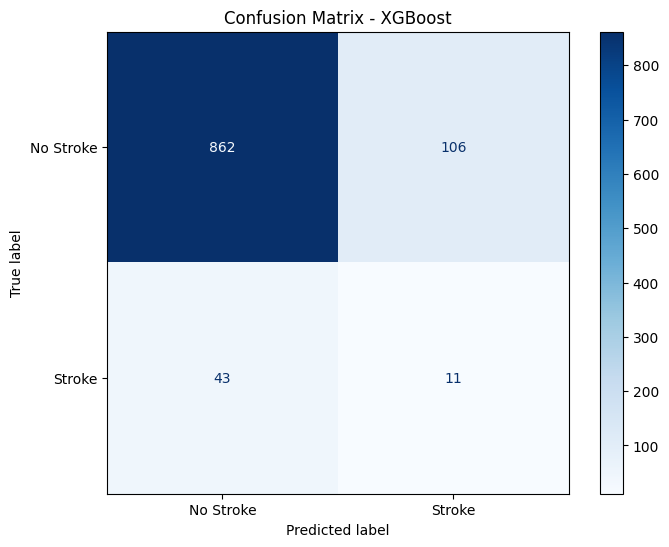

In [10]:
# === Confusion Matrix ===
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generowanie confusion matrix
cm = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Stroke", "Stroke"])

# Wykres confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
cmd.plot(ax=ax, cmap="Blues", values_format="d")
plt.title("Confusion Matrix - XGBoost")
plt.grid(False)
plt.show()